<a href="https://colab.research.google.com/github/abhibeats95/GMML/blob/main/GMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Fri Jul 22 02:34:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pytorch-lightning-bolts==0.3.2
!pip install lightning-bolts==0.4.0
!pip install ndg-httpsclient==0.5.1
!pip install pytorch-lightning==1.4.9
!pip install neptune-client==0.14.2
!pip install urllib3==1.26.7
!pip install neptune-contrib
!pip install pytorch-lightning
!pip install faiss
!pip install timm
!pip install faiss-cpu --no-cache
!pip install sacred
#!pip install faiss-gpu cudatoolkit=10 -c pytorch
#! python <executable_file.py> # Link for executing any python file
!pip install --upgrade torch==1.9.0
!pip install --upgrade torchvision==0.10.0
!pip install --upgrade torchmetrics==0.6.0
!pip install torchtext==0.10.0
!pip install addict
!pip install yapf

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
import torch 
print(torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
1.5.1+cu101


In [ ]:
import torch.nn.functional as F
from torchvision import transforms as tf 
from torchvision import transforms
import torch 
import torchvision
import torch.nn as nn
from PIL import ImageFilter, ImageOps, Image
import numpy as np 
import os 
import sys 
import random
import cv2
from numpy.random import randint
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import image
import math
from torchvision.datasets import CIFAR10
from torchvision.datasets.voc import VOCDetection
import xml.etree.ElementTree as ET
import json
import time
from pathlib import Path
import datetime
import torch.distributed as dist
from collections import defaultdict, deque
from traitlets.traitlets import Instance
import subprocess
import torch.backends.cudnn as cudnn
print(torch.__version__)

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

1.11.0+cu113
Training on device cuda.


In [ ]:
def get_sha():
    cwd = os.path.dirname(os.path.abspath(__file__))

    def _run(command):
        return subprocess.check_output(command, cwd=cwd).decode('ascii').strip()
    sha = 'N/A'
    diff = "clean"
    branch = 'N/A'
    try:
        sha = _run(['git', 'rev-parse', 'HEAD'])
        subprocess.check_output(['git', 'diff'], cwd=cwd)
        diff = _run(['git', 'diff-index', 'HEAD'])
        diff = "has uncommited changes" if diff else "clean"
        branch = _run(['git', 'rev-parse', '--abbrev-ref', 'HEAD'])
    except Exception:
        pass
    message = f"sha: {sha}, status: {diff}, branch: {branch}"
    return message


In [ ]:
dist_url="env://"
def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print

def init_distributed_mode():
    # launched with torch.distributed.launch
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        rank = int(os.environ["RANK"])
        world_size = int(os.environ['WORLD_SIZE'])
        gpu = int(os.environ['LOCAL_RANK'])
    # launched with submitit on a slurm cluster
    elif 'SLURM_PROCID' in os.environ:
        rank = int(os.environ['SLURM_PROCID'])
        gpu = rank % torch.cuda.device_count()
    # launched naively with `python main_dino.py`
    # we manually add MASTER_ADDR and MASTER_PORT to env variables
    elif torch.cuda.is_available():
        print('Will run the code on one GPU.')
        rank, gpu,world_size = 0, 0, 1
        os.environ['MASTER_ADDR'] = '127.0.0.1'
        os.environ['MASTER_PORT'] = '29500'
    else:
        print('Does not support training without GPU.')
        sys.exit(1)

    distributed = True
    dist.init_process_group(
        backend="nccl",
        init_method=dist_url,
        world_size=world_size,
        rank=rank,
    )

    torch.cuda.set_device(gpu)
    print('| distributed init (rank {}): {}'.format(
        rank, dist_url), flush=True)
    dist.barrier()
    setup_for_distributed(rank == 0)



In [ ]:
def fix_random_seeds(seed=31):
    """
    Fix random seeds.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [ ]:
def clip_gradients(model, clip):
    norms = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            norms.append(param_norm.item())
            clip_coef = clip / (param_norm + 1e-6)
            if clip_coef < 1:
                p.grad.data.mul_(clip_coef)
    return norms
    
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()

def is_main_process():
    return get_rank() == 0


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.6f}')
        data_time = SmoothedValue(fmt='{avg:.6f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.6f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.6f} ({global_avg:.6f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
        
def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#path= '/content/gdrive/MyDrive/Colab Notebooks/Individual_Images /Screenshot (212).png'
#img=Image.open(path)
#img=cv2.imread(path)

#img=torch.from_numpy(img)
#per_img=img.permute(2,0,1)
#img.shape

In [ ]:
class Gaussian_Blur():
  def __init__(self,p=0.5, radius_min=0.1, radius_max=2.0):
    self.prob=p
    self.radius_min= radius_min
    self.radius_max= radius_max

  def __call__(self,img):
    do_it= random.random() <=self.prob

    if not do_it:
      return img 

    return img.filter(ImageFilter.GaussianBlur(
        radius=random.uniform(self.radius_min, self.radius_max)
           )
    )

class solarization(object):
  def __init__(self,p):
    self.p=p
  
  def __call__(self,img):
    if random.random()<self.p:
      return ImageOps.solarize(img)

    else:
      return img 


In [ ]:
def GMML_drop_rand_patches(X, X_rep=None, drop_type='noise', max_replace=0.7, align=16, max_block_sz=0.3):
    #######################
    # max_replace: percentage of image to be replaced
    # align: align corruption with the patch sizes
    # max_block_sz: percentage of the maximum block to be dropped
    #######################
   
    np.random.seed()    
    C, H, W = X.size()
    n_drop_pix = np.random.uniform(min(0.5, max_replace), max_replace)*H*W
    mx_blk_height = int(H*max_block_sz)
    mx_blk_width = int(W*max_block_sz)
    
    align = max(1, align)
    
    mask = torch.zeros_like(X)
    drop_t = np.random.choice(drop_type.split('-'))
    
    while mask[0].sum() < n_drop_pix:
        
        ####### get a random block to replace 
        rnd_r = ( randint(0, H-align) // align ) * align
        rnd_c = ( randint(0, W-align) // align ) * align

        rnd_h = min(randint(align, mx_blk_height), H-rnd_r)
        rnd_h = round( rnd_h / align ) * align
        rnd_w = min(randint(align, mx_blk_width), W-rnd_c)
        rnd_w = round( rnd_w / align ) * align
        
        if X_rep is not None:
            X[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w] = X_rep[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w].detach().clone()
        else:
            if drop_t == 'noise':
                X[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w] = torch.empty((C, rnd_h, rnd_w), dtype=X.dtype, device=X.device).normal_()
            elif drop_t == 'zeros':
                X[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w] = torch.zeros((C, rnd_h, rnd_w), dtype=X.dtype, device=X.device)
            else:
                ####### get a random block to replace from
                rnd_r2 = (randint(0, H-rnd_h) // align ) * align
                rnd_c2 = (randint(0, W-rnd_w) // align ) * align
            
                X[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w] = X[:, rnd_r2:rnd_r2+rnd_h, rnd_c2:rnd_c2+rnd_w].detach().clone()
            
        mask[:, rnd_r:rnd_r+rnd_h, rnd_c:rnd_c+rnd_w] = 1 
         
    return X, mask

In [ ]:
class DataAugmentationSiT(object):
   def __init__(self,drop_per,drop_type,drop_align,img_size, global_crop_scale,local_crop_scale,local_num_crop=0):
     # for corruption
     self.drop_per=drop_per
     self.drop_type= drop_type
     self.drop_align= drop_align
   

     self.global_crop_scale=global_crop_scale
     self.local_crop_scale= local_crop_scale
     self.local_num_crop=local_num_crop



     self.img_size= img_size

     self.rand_resize_and_flip=tf.Compose([
               tf.RandomResizedCrop(img_size, scale=global_crop_scale, interpolation=Image.BICUBIC),
               tf.RandomHorizontalFlip(p=0.5)
               ])
   
     self.rand_resize_and_flip_local=tf.Compose([
               tf.RandomResizedCrop(96, scale=local_crop_scale, interpolation=Image.BICUBIC),
               tf.RandomHorizontalFlip(p=0.5)
               ])
   
   ##light Color jittering
     self.color_jitter1= tf.Compose([
                                   tf.RandomApply([tf.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.1)],p=0.3),
   ])

   ## harsh color jitter for SiT model
     self.color_jitter2= tf.Compose([
                                   tf.RandomApply([tf.ColorJitter(brightness=0.4, contrast=0.4,saturation=0.2, hue=0.1)], p=0.8),
                                   tf.RandomGrayscale(p=0.2),
                                   
   ])

     normalize= tf.Compose([
                          tf.ToTensor(),
                          tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   ])


     self.clean_trasn=tf.Compose([
                                self.color_jitter1,
                                Gaussian_Blur(0.1),
                                normalize,


   ])

     self.corpt_trans=tf.Compose([
                                self.color_jitter2,
                                Gaussian_Blur(1.0),
                                solarization(0.2),
                                normalize,
   ])
   
   def __call__(self, image):

     clean_crop=[]
     corpt_crop=[]
     mask_crop=[]

     ##augmentation 1
     im = self.rand_resize_and_flip(image)
     im_orig=self.clean_trasn(im)
     im_croupt=im_orig.detach().clone()
     im_mask=torch.zeros_like(im_croupt)

     if self.drop_per>0:
       im_croupt,im_mask=GMML_drop_rand_patches(im_croupt,max_replace=self.drop_per,align=self.drop_align, drop_type=self.drop_type)
       
     clean_crop.append(im_orig)
     corpt_crop.append(im_croupt)
     mask_crop.append(im_mask)

     ##augmentation 2
     im =self.rand_resize_and_flip(image)
     im_orig=self.clean_trasn(im)
     im_croupt=im_orig.detach().clone()
     im_mask=torch.zeros_like(im_croupt)

     if self.drop_per>0:
       im_croupt, im_mask= GMML_drop_rand_patches(im_croupt,max_replace=self.drop_per, align=self.drop_align,drop_type=self.drop_type)

     clean_crop.append(im_orig)
     corpt_crop.append(im_croupt)
     mask_crop.append(im_mask)


     ##local crop augmentation

     for _ in range(self.local_num_crop):
       im= self.rand_resize_and_flip_local(image)

       im_orig= self.clean_trasn(im)
       im_croupt = im_orig.detach().clone()

       if self.drop_per>0:
         im_croupt, im_mask= GMML_drop_rand_patches(im_croupt, max_replace=self.drop_per,align=self.drop_align,drop_type=self.drop_type)
      
       clean_crop.append(im_orig)
       corpt_crop.append(im_croupt)
       mask_crop.append(im_mask)
       
     return clean_crop, corpt_crop, mask_crop

# Taking the clean , corrupt nad mask images compers by noiseing and droping block augmentations applied by DataAugmentationSIT
# and giving new corrpted and mask image clean images is replced by area of another image, this will generate the new corrupt image and mask
def GMML_replace_list(samples, corrup_ver, mask_ver,drop_replace,drop_type,drop_align):
  if not isinstance(samples, list):
    samples=[samples]

  rep_drop=1 if drop_type=='' else ( 1 / ( len(drop_type.split('-')) + 1 ) )

  n_imgs= samples[0].size()[0]## number of images in batch
  masks_all = []
  aug_all = []
  for si, s in enumerate(samples):
        samples_aug = s.detach().clone()
        masks = torch.zeros_like(samples_aug)
        for i in range(n_imgs):
            idx_rnd = randint(0, n_imgs)
            if random.random() < rep_drop:
              samples_aug[i], masks[i] = GMML_drop_rand_patches(samples_aug[i], samples[si][idx_rnd], max_replace=drop_replace, align=drop_align)
            else:
              samples_aug[i], masks[i] = corrup_ver[si][i], mask_ver[si][i]
        #samples[si] = samples_aug
        masks_all.append(masks)
        aug_all.append(samples_aug)
      
  return aug_all, masks_all

In [ ]:
#!tar -xvf "/content/drive/MyDrive/Colab Notebooks/Images/Dataset/pascal/VOCtrainval_06-Nov-2007.tar" -C "/content/drive/MyDrive/Colab Notebooks/Images/Dataset/pascal"
#sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)

In [ ]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size,in_chan, embed_dim):
        super().__init__()

        num_patches=(img_size//patch_size)*(img_size//patch_size)

        self.img_size=img_size
        self.patch_size=patch_size
        self.num_patches=num_patches
        self.in_chan=in_chan
        self.proj=nn.Conv2d(in_chan,embed_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self,x):
        B,C,H,W=x.shape
        x=self.proj(x).flatten(2).transpose(1,2)
        return x
  
class Attention(nn.Module):
    def __init__(self,dim, num_heads,qkv_bias=False, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()

        self.num_heads=num_heads
        head_dim=dim//num_heads

        self.scale= qk_scale or head_dim**-0.5

        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop=nn.Dropout(attn_drop)
        self.proj=nn.Linear(dim, dim)
        self.proj_drop=nn.Dropout(proj_drop)


    def forward(self,x):
        B,N,C=x.shape

        qkv=self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]

        attn=(q@k.transpose(-2,-1))*self.scale
        attn=attn.softmax(dim=-1)
        attn=self.attn_drop(attn)

        x=(attn@v).transpose(-3,-2).flatten(2)
        x=self.proj(x)
        x=self.proj_drop(x)

        return x , attn


class MLP(nn.Module):
    def __init__(self,in_features,hidden_features=None,out_features=None ,act_layer=nn.GELU,drop=0):
        super().__init__()

        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1  = nn.Linear(in_features, hidden_features)
        self.act  = act_layer()
        self.fc2  = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)


    def forward(self,x):
        x=self.fc1(x)
        x=self.act(x)
        x=self.drop(x)
        x=self.fc2(x)
        x=self.drop(x)
        return x


class Block(nn.Module):
    def __init__ (self,dim, num_heads, mlp_ratio=4.0, qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
    
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attn=Attention(dim,num_heads,qkv_bias,qk_scale,attn_drop,proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        
        x = x + self.drop_path(y)
        #droped = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        #x=y+x
        #x=x+self.mlp(self.norm2(x))
        
        
        if return_attention:
            return x, attn
        
        return x#,droped

In [ ]:
class vit(nn.Module):
    def __init__(self, num_classes=0,
                 img_size=224, 
                 patch_size=16,
                 in_channels=3 ,
                 embed_dim=384,
                 depth=12, 
                 num_heads=6,
                 mlp_ratio=4,
                 qkv_bias=True, 
                 qk_scale=None, 
                 drop_rate=0.0,
                 attn_drop_rate=0.0,
                 drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm,
                 head_data=True,
                 head_class=True,**kwargs):
    
        super(vit,self).__init__()

        self.patch_size=patch_size
        self.img_size=img_size
        self.embed_dim=embed_dim
        self.in_channels=in_channels
    

        self.num_features=self.embed_dim=embed_dim

        self.patch_embed=PatchEmbed(img_size,patch_size=patch_size, in_chan=in_channels,embed_dim=embed_dim)
    
        num_patches=self.patch_embed.num_patches

        self.cls_token =nn.Parameter(torch.zeros(1,1,embed_dim))

        self.pos_embed= nn.Parameter(torch.zeros(1,num_patches+1,embed_dim))

        self.pos_drop=nn.Dropout(drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.norm = norm_layer(embed_dim)

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, norm_layer=norm_layer,drop_path=dpr[i])
            for i in range(depth)])
    
        

        self.head_class = nn.Linear(embed_dim, num_classes) if (num_classes > 0 and head_class==True) else nn.Identity()

        self.head_data  = nn.Sequential(nn.Linear(embed_dim, mlp_ratio*embed_dim), nn.GELU(),
                                        nn.Linear(embed_dim*mlp_ratio, num_classes)) if (num_classes > 0 and head_data==True) else nn.Identity()
        
                            
     #trunc_normal_(self.pos_embed, std=.02)
     #trunc_normal_(self.cls_token, std=.02)
     #def _init_weights(self, m):
     #   if isinstance(m, nn.Linear):
     #      trunc_normal_(m.weight, std=.02)
     #     if isinstance(m, nn.Linear) and m.bias is not None:
     #           nn.init.constant_(m.bias, 0)
     #  elif isinstance(m, nn.LayerNorm):
     #     nn.init.constant_(m.bias, 0)
     #    nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):

        npatch = x.shape[1] - 1

        N = self.pos_embed.shape[1] - 1

        if npatch == N and w == h:
            return self.pos_embed

        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        w0, h0 = w0 + 0.1, h0 + 0.1
        
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)
        
    def prepare_tokens(self, x):

        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x, recons_blocks='', classify=False):

        r_blocks=[-1] if recons_blocks=='' else list(map(int, recons_blocks.split('-')))

        x=self.prepare_tokens(x)#Tokens with positional information

        recons,cnt=0,0
        
        for i, blk in enumerate(self.blocks):

          x=blk(x)

          if(i+1) in r_blocks:
            recons=recons+x
            cnt+=1
          
          
        if classify==True:
           x=self.norm(x)
           return self.head_class(x[:,0]), self.head_data(torch.mean(x[:,1:],dim=1))

        if cnt!=0:
          recons/=cnt
          recons=self.norm(recons)
          return recons[:,1:]

        return x[:,1:]


    def get_last_features_attn(self,x):##patches are directly feed to all the trans layers and attn map is only taken from last block only.

        x=self.prepare_tokens(x)
    

        for i, blk in enumerate(self.blocks):
          
          if i==(len(self.blocks)-1):
            x,attention=blk(x, return_attention=True)
            return self.norm(x), attention

          else:
            x=blk(x)
            
    def get_all_feature_attention(self,x):
        x=self.prepare_tokens(x)

        attn_list=[]
        for i, blk in enumerate(self.blocks):
          x,attention=blk(x, return_attention=True)

          attn_list.append(attention)

        return attn_list

In [ ]:
ten=torch.rand([1,3,224,224])
m=vit()
m(ten).shape

torch.Size([1, 196, 384])

In [ ]:
class recons_decoder(nn.Module):
  
    def __init__(self,in_dim, in_channels,patch_size):
        super().__init__()

        self.mlp1 = nn.Linear(in_dim,in_dim)
        self.mlp2 = nn.Linear(in_dim,in_dim)
        self.mlp3 = nn.Linear(in_dim,in_dim)
        self.act=nn.GELU()

        self.convtrans = nn.ConvTranspose2d(in_channels=in_dim, out_channels=in_channels,kernel_size=(patch_size,patch_size), stride=(patch_size,patch_size))

    def forward(self,encodings):
        x=self.mlp1(encodings)
        x=self.act(x)
        x=self.mlp2(x)
        x=self.act(x)
        x=self.mlp3(x)
        x=self.act(x)#[10,196,768]

        x_rec=x.transpose(1,2)#[10,768,196]
        
        w,h=int(math.sqrt(x_rec.size()[2])),int(math.sqrt(x_rec.size()[2]))#[14,14]

        x_rec=x_rec.reshape(x_rec.size()[0],x_rec.size()[1],w,h)#[10,768,14,14]

        x_rec=self.convtrans(x_rec)#[10,3,224,224]

        return x_rec

        

In [ ]:
class encoder_decoder(nn.Module):
    def __init__(self,encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        
        

    def forward(self,x,recons_blocks,global_crop=2):
        reconstructed_img=self.decoder(self.encoder(torch.cat(x[0:global_crop]), recons_blocks))

        return reconstructed_img

In [ ]:
f=[torch.rand([10,3,224,224]),torch.rand([10,3,224,224])]
encoder=vit()

embed_dim,in_channels,patch_size= encoder.embed_dim,encoder.in_channels,encoder.patch_size
  
decoder=recons_decoder(embed_dim, in_channels, patch_size)

model=encoder_decoder(encoder,decoder)##if no reconstruction block then last block output will come without class info i.e x[:,1:] 
model(f, recons_blocks='5-6-7').shape

torch.Size([20, 3, 224, 224])

In [ ]:
#!pip install --upgrade torchvision

In [ ]:
raw_data=VOCDetection(root='/content/gdrive/MyDrive/voc/Pascal_2007',
                     year='2007',
                     image_set='trainval',
                    download=True,
                     transform=None)

In [ ]:
from torch.utils.data.dataset import Dataset
class Custom_Voc(Dataset):
    def __init__(self, json_file, transform):
        with open(json_file) as f:
            self.data = json.load(f)
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        d = self.data[idx]
        image_path = d['image']
        #boxes = d['boxes']
        classes = d['classes']
        #difficulties = d['difficulties']
        #seg_map = d['Seg_map']

        #if len(boxes) == 0:
         #   boxes = [[0, 0, 0, 0]]
          #  classes = [BACKGROUND_INDEX]
           # difficulties = [0]

        image = Image.open(image_path).convert('RGB')
        #boxes = torch.FloatTensor(boxes)
        #difficulties = torch.LongTensor(difficulties)
        #image = Image.open(seg_map)
        classes = torch.LongTensor(classes)
        image = self.transform(image)
        return image#,classes

def get_params_groups(model):
    regularized = []
    not_regularized = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        # we do not regularize biases nor Norm parameters
        if name.endswith(".bias") or len(param.shape) == 1:
            not_regularized.append(param)
        else:
            regularized.append(param)
    return [{'params': regularized}, {'params': not_regularized, 'weight_decay': 0.}]
    

def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule
    

In [ ]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    image_width = int(root.find('size').find('width').text)
    image_height = int(root.find('size').find('height').text)
    boxes, classes, difficulties = [], [], []
    for object in root.iter('object'):
     #--#   bndbox = object.find('bndbox')
      #--#  xmin = int(bndbox.find('xmin').text) - 1
       #--# ymin = int(bndbox.find('ymin').text) - 1
        #--#xmax = int(bndbox.find('xmax').text) - 1
        #--#ymax = int(bndbox.find('ymax').text) - 1
        #--#boxes.append([xmin, ymin, xmax, ymax])

        label = object.find('name').text.lower().strip()
        classes.append(label)

        #--#difficulty = int(object.find('difficult').text == '1')
        #--#difficulties.append(difficulty)
    #--#return boxes, classes, difficulties
    return classes

file_root='/content/gdrive/MyDrive/voc/VOCdevkit/VOC2012'
class_names = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
        'train', 'tvmonitor']


nb_classes=20

def save_as_json(basename, dataset):
    filename = os.path.join(os.path.dirname(file_root), basename)
    print("Saving %s ..." % filename)
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=2)


def prepare_dataset(file_root,class_names,Img_set_to_text,json_name):
    
    text_file=os.path.join(file_root,Img_set_to_text)
    train_dataset=[]
    with open(text_file) as f:
      ids = [line.strip() for line in f.readlines()]
    for id in ids:
      
      image_path=os.path.join(file_root,'JPEGImages',id+'.jpg')
      annotations_path=os.path.join(file_root,'Annotations',id+'.xml')
      #seg_path= os.path.join(file_root,'SegmentationClass',id+'.png')
      #boxes,classes , difficulties=parse_annotation(annotation_path=annotations_path)
      classes=parse_annotation(annotation_path=annotations_path)
      
      classes = [class_names.index(c) for c in classes]
      train_dataset.append(
                {
                     'image':   os.path.abspath(image_path),
                     #'Seg_map': os.path.abspath(seg_path),
                     #'boxes': boxes,
                     'classes': classes
                     #'difficulties': difficulties
                }
            )
    save_as_json(json_name,train_dataset)

    return train_dataset

In [ ]:
a=os.listdir('/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/VOC2007/SegmentationObject')

In [ ]:
#file_root='/content/gdrive/MyDrive/voc/VOCdevkit/VOC2012';
#Img_set_to_text='ImageSets/Main/trainval.txt'
#prepare_dataset(file_root,class_names,Img_set_to_text,'2012_train_val.json')

In [ ]:
file_root='/content/gdrive/MyDrive/voc/VOCdevkit/VOC2012'
#prepare_dataset(file_root,class_names)
json_file='/content/gdrive/MyDrive/voc/VOCdevkit/2012_train_val (1).json'
#json_file_mini_5='/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/mini_5.json'

custom_transform=DataAugmentationSiT(drop_per=0.7,drop_type='noise', drop_align=16, img_size=224, global_crop_scale=(0.25,1.0),local_crop_scale=(0.05,0.4))
custom_dataset=Custom_Voc(json_file,transform=custom_transform)

In [ ]:
#init_distributed_mode()
sampler = torch.utils.data.DistributedSampler(custom_dataset, shuffle=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(custom_dataset,batch_size=1,num_workers=2, pin_memory=True)#, drop_last=True
len(data_loader)##look in datasaet length it should be more than 646 ----------------------------------------------------------------

11540

In [ ]:
model=encoder_decoder(encoder,decoder).to(device=device)
#model=model.cuda()
#next(model.parameters()).is_cuda #boolean check 
num_iter_pe= len(data_loader)
parms=get_params_groups(model)
optimizer =torch.optim.AdamW(parms)
lr_schedule=cosine_scheduler(base_lr,final_lr, epochs,num_iter_pe,warmup_epochs,start_warmup_value=0)
wd_schedule=cosine_scheduler(weight_decay_base, weight_decay_end,epochs,num_iter_pe)


In [ ]:
def get_params_groups(model):
    regularized = []
    not_regularized = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        # we do not regularize biases nor Norm parameters
        if name.endswith(".bias") or len(param.shape) == 1:
            not_regularized.append(param)
        else:
            regularized.append(param)
    return [{'params': regularized}, {'params': not_regularized, 'weight_decay': 0.}]
    

In [ ]:
from collections import OrderedDict
def get_updated_dic(dic):
  new_dic= OrderedDict()
  #for k,v in dic['SiT_model'].items():
  for k,v in dic['student'].items():
      #name=k.replace('module.backbone.','encoder.')
      name=k.replace('module.backbone','module.encoder')
      #name=k
      new_dic[name]=v
      #new_dic[k]=v
  return new_dic

def restore_model(check_path,model,run_variables,epoch_load=False):
  check_point=torch.load(check_path,map_location='cpu')
  updated_dic=get_updated_dic(check_point)
  model.load_state_dict(updated_dic,strict=False)
  if epoch_load==True:
     run_variables['epoch'] = check_point['epoch']

#ck='/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/VOC2007/checkpoint.pth'
#to_restore={'epoch':0}
#run_variables=to_restore
#restore_model(ck,model,run_variables=to_restore,epoch_load=False)


In [ ]:
check_point=torch.load(mc_ssl,map_location='cpu')
#model.load_state_dict(check_point['student'],strict=False)
#restore_model(mc_ssl,model,run_variables={'epoch':0}, epoch_load=False)
#for x, y in check_point['student'].items():
 # print(x)

In [ ]:
model.cuda()  
model = nn.parallel.DistributedDataParallel(model, device_ids=[0],find_unused_parameters=True)# distributing the entire model to single gpu


In [ ]:
for name, child in model.named_parameters():
  if name =='module.module.encoder.blocks.1.attn.proj.weight':
    print(name)

module.module.encoder.blocks.1.attn.proj.weight


In [ ]:
def train(epochs,
          recons_blocks,
          drop_per,
          drop_type,
          drop_align,
          drop_replace,
          img_size,
          batch_size,
          json_file_path,
          check_path,
          epoch_load=False,
          use_fp16=False,
          global_crop_scale=(0.25,1.0),
          local_crop_scale=(0.05,0.4)):
  #init_distributed_mode()
  fix_random_seeds(seed)#
  cudnn.benchmark=True
  epochs+=1

  custom_transform=DataAugmentationSiT(drop_per,drop_type, drop_align,img_size=img_size, global_crop_scale=global_crop_scale,local_crop_scale=(0.05,0.4),)
  
  custom_dataset=Custom_Voc(json_file_path,transform=custom_transform)
  
  sampler = torch.utils.data.DistributedSampler(custom_dataset, shuffle=True)
  
  data_loader = torch.utils.data.DataLoader(custom_dataset,sampler=sampler, batch_size=batch_size,num_workers=1, pin_memory=True)#, drop_last=True

  num_iter_pe=len(data_loader)

  print(f"--------The dataset consists of {len(custom_dataset)} images")

  encoder=vit()
  
  
      
  encoder_before_parameter = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
  print(f'Number of encoder parameter before freeze{encoder_before_parameter}')
  
  


  embed_dim,in_channels,patch_size= encoder.embed_dim,encoder.in_channels,encoder.patch_size

  decoder=recons_decoder(embed_dim, in_channels, patch_size)
  decoder_before_parameter=sum(p.numel() for p in decoder.parameters() if p.requires_grad)
  print(f'Number of decoder parameter before freeze{decoder_before_parameter}')


  model=encoder_decoder(encoder,decoder)##if no reconstruction block then last block output will come without class info i.e x[:,1:] 

  model_before_parameter=sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Number of model parameter before freeze{model_before_parameter}')
   
  model=model.cuda()### sending the model to gpu

  ## Restarting Process
  model = nn.parallel.DistributedDataParallel(model, device_ids=[0],find_unused_parameters=True)# distributing the entire model to single gpu

  to_restore={'epoch':0}
  restore_model(check_path,model,run_variables=to_restore,epoch_load=epoch_load)
  
  #for idx,(name, child) in enumerate(model.named_parameters()):
   # if idx<78:#freeze till block 5:
    #  child.requires_grad=False

  model_before_parameter=sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Number of model parameter before freeze{model_before_parameter}')
  
  #for name, child in model.named_children():
  #       if name =='encoder':
  #         for param in child.parameters():
  #           param.requires_grad=False
  #       if name =='decoder':
   #        for param in child.parameters():
    #         param.required_grade=True
             
  
  
  

  

  print(f'Total epochs {epochs}')

  params_groups=get_params_groups(model)
  optimizer = torch.optim.AdamW(params_groups)
  #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)
  fp16_scaler = torch.cuda.amp.GradScaler() if use_fp16 else None
  fp16_scaler.load_state_dict(torch.load(check_path,map_location='cpu')['fp16_scaler'])
  #optimizer.load_state_dict(torch.load(check_path,map_location='cpu')['optimizer'])


  lr_schedule=cosine_scheduler(base_lr,final_lr, epochs,num_iter_pe,warmup_epochs,start_warmup_value=0)
  wd_schedule=cosine_scheduler(weight_decay_base, weight_decay_end,epochs,num_iter_pe)

  start_epoch= to_restore['epoch']

  start_time= time.time()
  print(f"==> Start training from epoch {start_epoch}")
  n_params_after = sum(p.numel() for p in encoder.parameters() if p.requires_grad)

  print(f"-------> The encoder has {n_params_after} parameters after freeze.")  
  
  for epoch in range(start_epoch, epochs):
    data_loader.sampler.set_epoch(epoch)
    train_stats=train_one_epoch(model,data_loader,optimizer,lr_schedule,wd_schedule,epoch,fp16_scaler,drop_replace,recons_blocks)
    save_dict = {'SiT_model': model.state_dict(), 'optimizer': optimizer.state_dict(),'epoch': epoch + 1}
    print(f'current epoch is {epoch}')


    if fp16_scaler is not None:
            save_dict['fp16_scaler'] = fp16_scaler.state_dict()

    save_on_master(save_dict, os.path.join(output_dir, '/checkpoint.pth'))
    if saveckp_freq and epoch % saveckp_freq == 0:
      save_on_master(save_dict, os.path.join(output_dir, f'checkpoints/checkpoint{epoch:04}.pth'))
    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()}, 'epoch': epoch}
    if is_main_process():
       with (Path(output_dir) / "log.txt").open("a") as f:
         f.write(json.dumps(log_stats) + "\n")
                
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))
 
    

In [ ]:
def train_one_epoch(Model,data_loader,optimizer,lr_schedule,wd_schedule,epoch,fp16_scaler,drop_replace, recons_blocks):

  save_recon = os.path.join(output_dir, 'reconstruction_samples')
  Path(save_recon).mkdir(parents=True, exist_ok=True)

  plot=True
  metric_logger=MetricLogger(delimiter=' ')
  header ='Epoch: [{}/{}]'.format(epoch,epochs)
  for it, ccm in enumerate(metric_logger.log_every(data_loader,100,header)):
    cleans , corrupteds, masks=ccm[0],ccm[1],ccm[2]

    it= len(data_loader)*epoch + it# get index for the parameter which will be updates in each step(after evey batch)41*0+0 means 0rth parmeter update, then it=1,2,3,4 will give index for param 1,2,3,4 same hapen when epoch increases to 1.
    for i , param_group in enumerate(optimizer.param_groups):
      param_group['lr']=lr_schedule[it]
      if i==0:
        param_group['weight_decay']=wd_schedule[it]
    
    ##Moving images to GPU
    cleans = [im.cuda(non_blocking=True) for im in cleans]## Non_blocking increase  the speed when next operation doesnt depend on previous step and asy data transfer is possible, where as pin_memory= True is used when data need to move form CPU to GPU, data loader DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
    corrupteds = [im.cuda(non_blocking=True) for im in corrupteds]
    masks = [im.cuda(non_blocking=True) for im in masks]

    if drop_replace>0:
      corrupteds,masks=GMML_replace_list(cleans,corrupteds,masks,drop_replace=drop_replace,drop_type=drop_type,drop_align=drop_align)
      #print('replace applied')
      
    ##torch.cuda.amp.initialize(model,optimizer,opt_level)
    with torch.cuda.amp.autocast(fp16_scaler is not None):
      global_recon=Model(corrupteds,recons_blocks=recons_blocks)
      recloss=F.l1_loss(global_recon,torch.cat(cleans[0:2]),reduction='none')
      loss = recloss[torch.cat(masks[0:2])==1].mean() if (drop_only == 1) else recloss.mean()
      if plot==True and is_main_process and epoch%10 ==0:
        plot_=False
        print_out = save_recon + '/epoch_' + str(epoch).zfill(5)  + '.jpg'
        imagesToPrint = torch.cat([cleans[0][0: min(15, batch_size)].cpu(),  corrupteds[0][0: min(15, batch_size)].cpu(),
                                       global_recon[0: min(15, batch_size)].cpu(), masks[0][0: min(15, batch_size)].cpu()], dim=0)
        torchvision.utils.save_image(imagesToPrint, print_out, nrow=min(15, batch_size), normalize=True, range=(-1, 1))

    #if not math.isfinite(loss.item()):
     # print("Loss is {}, stopping training".format(loss.item()), force=True)
      #sys.exit(1)

    optimizer.zero_grad()
    param_norms = None
    if fp16_scaler is None:
      loss.backward()
      if clip_grad:
        param_norms = clip_gradients(Model,clip_grad)
      optimizer.step()
    
    else:
      fp16_scaler.scale(loss).backward()
      if clip_grad:
        fp16_scaler.unscale_(optimizer) 
        param_norms = clip_gradients(Model,clip_grad)
      fp16_scaler.step(optimizer)
      fp16_scaler.update()

    torch.cuda.synchronize()

    metric_logger.update(loss=loss.item())
    metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
        
        
        
  # gather the stats from all processes
  metric_logger.synchronize_between_processes()
  print("Averaged stats:", metric_logger)
  return {k: meter.global_avg for k, meter in metric_logger.meters.items()}#, model#,corrupteds,masks,corrupt,cleans,data_loader





In [ ]:
drop_per=0.7
drop_replace=0.3
drop_type='noise' 
drop_align=16
batch_size=16
#parameters for schedular
base_lr=0.0001#0.0005 orignal
final_lr=1e-6
epochs=800
warmup_epochs=0
weight_decay_base=0.04
weight_decay_end=0.4
drop_only=1
clip_grad=0
seed=0
use_fp16=True
saveckp_freq=5
output_dir='/content/gdrive/MyDrive/voc/VOCdevkit/model_outputs'
recons_blocks='6-8-10-12'
img_size=224
json_file_path='/content/gdrive/MyDrive/voc/VOCdevkit/2012_train_val (1).json'
json_file_mini_5='/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/mini_5.json'
json_file_mini_1='/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/mini_1.json'
mc_ssl='/content/gdrive/MyDrive/voc/VOCdevkit/model_outputs/checkpoint.pth'
epoch_250='/content/gdrive/MyDrive/voc/VOCdevkit/model_outputs/checkpoint0250.pth'
epoch_load=False


In [ ]:
train(epochs,recons_blocks,drop_per,drop_type,drop_align,drop_replace,img_size,batch_size,json_file_path=json_file_path,check_path=mc_ssl,epoch_load=epoch_load,use_fp16=use_fp16)#,check_path=epoch_31

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


--------The dataset consists of 11540 images
Number of encoder parameter before freeze21665664
Number of decoder parameter before freeze738435
Number of model parameter before freeze22404099
Number of model parameter before freeze22404099
Total epochs 801
==> Start training from epoch 0
-------> The encoder has 21665664 parameters after freeze.


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


Epoch: [0/800] [  0/722] eta: 0:13:58 loss: 0.966440 (0.966440) lr: 0.000010 (0.000010) wd: 0.040000 (0.040000) time: 1.160898 data: 0.505491 max mem: 3327
Epoch: [0/800] [100/722] eta: 0:05:01 loss: 0.978467 (0.997969) lr: 0.000010 (0.000010) wd: 0.040000 (0.040000) time: 0.501517 data: 0.000131 max mem: 3600
Epoch: [0/800] [200/722] eta: 0:04:11 loss: 0.761996 (0.942140) lr: 0.000010 (0.000010) wd: 0.040000 (0.040000) time: 0.482721 data: 0.000106 max mem: 3600
Epoch: [0/800] [300/722] eta: 0:03:23 loss: 0.642393 (0.858175) lr: 0.000010 (0.000010) wd: 0.040000 (0.040000) time: 0.480661 data: 0.000110 max mem: 3601
Epoch: [0/800] [400/722] eta: 0:02:34 loss: 0.596668 (0.796240) lr: 0.000010 (0.000010) wd: 0.040000 (0.040000) time: 0.480215 data: 0.000473 max mem: 3601
Epoch: [0/800] [500/722] eta: 0:01:46 loss: 0.558246 (0.754132) lr: 0.000010 (0.000010) wd: 0.040001 (0.040000) time: 0.471261 data: 0.000107 max mem: 3606
Epoch: [0/800] [600/722] eta: 0:00:58 loss: 0.577341 (0.725643) 

In [ ]:
params_groups=get_params_groups(model)
optimizer = torch.optim.AdamW(params_groups)


In [ ]:
#for x, y in torch.load(mc_ssl, map_location='cpu')['optimizer'].items():
  #for e,r in y.items():
    #for g,w in r.items():
      #if isinstance(w, torch.Tensor):
        #print(w.size())

In [ ]:
#for x, y in optimizer.state_dict().items():
 # for e,r in y.items():
  #  for g,w in r.items():
   #   if isinstance(w, torch.Tensor):
    #    print(w.size())

In [ ]:
#for x,y in torch.load(mc_ssl,map_location='cpu')['optimizer'].items():
  #print(y.items())

In [ ]:
for x, y in optimizer.state_dict().items():
  print(x)

state
param_groups


In [ ]:
for name, child in encoder.blocks.named_children():
  if name=='11':
    for param in child.parameters():
      param.requires_grad=True
    else:
      for param in child.parameters():
        param.requires_grad=False

In [ ]:
encoder=vit()

  

In [ ]:
for k, v in torch.load['optimizer'].items():
  print(k)

optimizer.load_state_dict(ck_gmml['optimizer']['state'])

state
param_groups


KeyError: ignored

In [ ]:
optim_state=check_point['optimizer']['state']

In [ ]:
#optimizer.load_state_dict(check_point['optimizer'])

In [ ]:
#ck_gmml['optimizer']['state']

In [ ]:
#for x, y in ck_gmml['optimizer']['state'].items():
  #    for r,f in y.items():
   #     print(r)

In [ ]:
state={'model':model}
from collections import OrderedDict



In [ ]:
#model.load_state_dict(ck_gmml['SiT_model'])

In [ ]:
from collections import OrderedDict

def get_updated_dic(dic):
  new_dic= OrderedDict()
  for k,v in dic['student'].items():
      name=k.replace('module.backbone.','encoder.')
      new_dic[name]=v
      return new_dic

def restore_model(check_path,model,run_variables,epoch_load=True):
  check_point=check_path=torch.load(check_path,map_location='cpu')
  updated_dic=get_updated_dic(check_point)
  model.load_state_dict(updated_dic,strict=False)
  
  if epoch_load==True:
     run_variables['epoch'] = check_point['epoch']
ck='/content/gdrive/MyDrive/Colab/Pascal_2007/VOCdevkit/VOC2007/checkpoint.pth'
to_restore={'epoch':0}
run_variables=to_restore
restore_model(ck,model,run_variables,epoch_load=True)

In [ ]:
#model.load_state_dict(new_dic,strict=False)

In [ ]:
ck_gmml['epoch']

6

In [ ]:
init_distributed_mode()
model.cuda()
model = nn.parallel.DistributedDataParallel(model, device_ids=[0],find_unused_parameters=True)

Will run the code on one GPU.
| distributed init (rank 0): env://


In [ ]:
model.stae

In [ ]:
new_dic= OrderedDict()
check_point=check_path=torch.load(ck,map_location='cpu')

for k,v in check_point['student'].items():
    name=k.replace('module.backbone.','module.encoder.')
    new_dic[name]=v
model.load_state_dict(new_dic,strict=False)


_IncompatibleKeys(missing_keys=['module.decoder.mlp1.weight', 'module.decoder.mlp1.bias', 'module.decoder.mlp2.weight', 'module.decoder.mlp2.bias', 'module.decoder.mlp3.weight', 'module.decoder.mlp3.bias', 'module.decoder.convtrans.weight', 'module.decoder.convtrans.bias'], unexpected_keys=['module.head.mlp.0.weight', 'module.head.mlp.0.bias', 'module.head.mlp.2.weight', 'module.head.mlp.2.bias', 'module.head.mlp.4.weight', 'module.head.mlp.4.bias', 'module.head.last_layer.weight_g', 'module.head.last_layer.weight_v', 'module.head_patch.mlp.0.weight', 'module.head_patch.mlp.0.bias', 'module.head_patch.mlp.2.weight', 'module.head_patch.mlp.2.bias', 'module.head_patch.mlp.4.weight', 'module.head_patch.mlp.4.bias', 'module.head_patch.last_layer.weight_g', 'module.head_patch.last_layer.weight_v', 'module.head_recons.mlp.0.weight', 'module.head_recons.mlp.0.bias', 'module.head_recons.mlp.2.weight', 'module.head_recons.mlp.2.bias', 'module.head_recons.convTrans.weight', 'module.head_recons.c

AttributeError: ignored

MOdel loading

In [ ]:
torch.save(model.state_dict(), filepath)

#Later to restore:
model.load_state_dict(torch.load(filepath))
model.eval()

state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    ...
}
torch.save(state, filepath)

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

for name, child in model.named_children():
    print(name)

for name, child in model.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False


optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)


SyntaxError: ignored

In [ ]:
for parm in child.parameters():
  parm.requires_grad=True

0

In [ ]:
for it, v in enumerate(data_loader):
    ##v(dim1 contains clean, corrupet and mask img), dim 2 contains 2 glolab crops for same image and dim 3 contains total images in the batch
    # Clean is list containg two 4d tensors each have batch of 32X3X224X224 images
    clean, corrupt, mask= v[0],v[1],v[2]
    break

In [ ]:
corrupt,mask=GMML_replace_list(clean, corrupt,mask, drop_type=drop_type, max_replace=drop_per,align=drop_align)

In [ ]:
one_img=[clean[0][1].unsqueeze(0),clean[1][1].unsqueeze(0)]#both global

In [ ]:
gloabl_recon=model(corrupt,recons_blocks='5-6-7')

In [ ]:
recloss = F.l1_loss(gloabl_recon, torch.cat(clean[0:2]), reduction='none')

torch.Size([32, 3, 224, 224])

In [ ]:
len(gloabl_recon)

2

In [ ]:
y=gloabl_recon[1].cpu().detach().clone()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


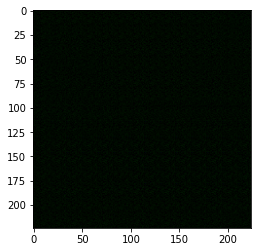

In [ ]:
plt.imshow(y.permute(1,2,0)) 

In [ ]:
corrupt_list=[corrupt[0][1],corrupt[1][1]]
len(corrupt)


2

In [ ]:
global_recon=model(corrupt, recons_blocks='5-6-7').shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


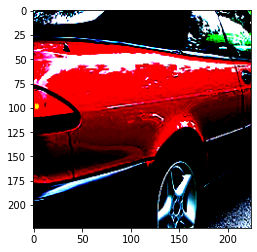

In [ ]:
plt.imshow(clean[0][1].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


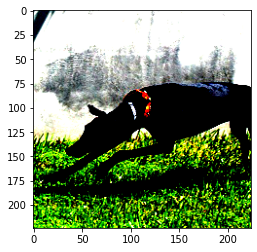

In [ ]:
plt.imshow(clean[0][31].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


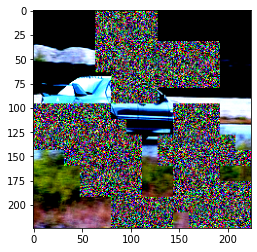

In [ ]:
plt.imshow(corrupt[0][8].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


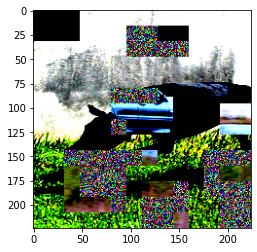

In [ ]:
plt.imshow(aug.permute(1,2,0))

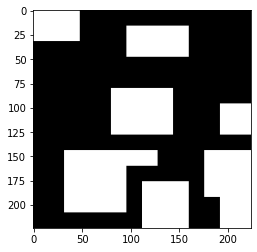

In [ ]:
plt.imshow(aft_mask.permute(1,2,0))


In [ ]:
drop_type='noise'
( 1 / ( len(drop_type.split('-')) + 1 ) )

0.16666666666666666

In [ ]:
clean=v[1]
corrupt=v[2]


In [ ]:
for x,y in enumerate(clean):
  break


In [ ]:
y[1].shape

torch.Size([3, 224, 224])

In [ ]:
clean[1][4].shape

torch.Size([3, 224, 224])

In [ ]:
for si,s in enumerate(clean 
                      )

32

In [ ]:
it=1*len(data_loader)+0
lr_schedule[]

5.0239234449760764e-05

In [ ]:
optimizer.par

In [ ]:
to_restore={'epoch':0}
### info for starting the trainig from check point

start_epoch=to_restore['epoch']

start_time=time.time()
print(f"==> Start training from epoch {start_epoch}")
for epoch in range(start_epoch,epochs):
  train_one_epoch()

In [ ]:
for it, v in enumerate(data_loader):
  clean, corrupt, mask=v[0],v[1],v[2]##v(dim1 contains clean, corrupet and mask img), dim 2 contains 2 glolab crops for same image and dim 3 contains total images in the batch  
  break

In [ ]:
#encoder=vit()


19891200

In [ ]:
warmup_epoch=10
warmup_iter=warmup_epoch*len(data_loader)
1e-6

In [ ]:
ff=np.arange(800 * 21 - 210)
ff

array([    0,     1,     2, ..., 16587, 16588, 16589])

In [ ]:
#for img, v in enumerate(data_loader):
 # print(img)
for it, v in enumerate(data_loader):
  clean, corrupt, mask=v[0],v[1],v[2]
  break



In [ ]:
from collections import defaultdict, deque
defaultdict(SmoothedValue)

In [ ]:
#v[2][1][1]
plt.imshow(v[2][1][24].permute(1,2,0))

IndexError: ignored

In [ ]:
Image.open('/content/gdrive/MyDrive/Colab/Images/VOCdevkit/VOC2007/JPEGImages/000954.jpg')

UnidentifiedImageError: ignored

In [ ]:
for x, y in enumerate(data_loader):
  print(x)
  print(y)
  break

TypeError: ignored

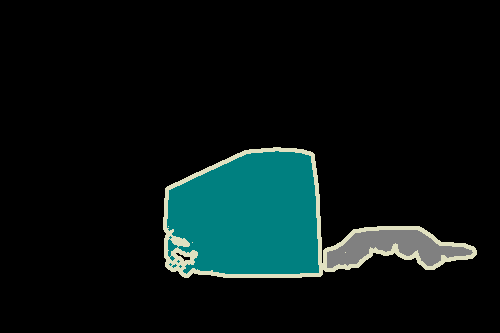

In [ ]:
with open('/content/gdrive/MyDrive/Colab/Images/VOCdevkit/trainval.json') as f:
  data=json.load(f)
torch.LongTensor(data[1]['classes'])
Image.open('/content/gdrive/MyDrive/Colab/Images/VOCdevkit/VOC2007/SegmentationClass/003195.png')

In [ ]:
def collate_fn(batch):
    images, boxes, classes, difficulties = zip(*batch)
    images = torch.stack(images, axis=0)
    return images, boxes, classes, difficulties

In [ ]:
def create_dataloader(json_file, batch_size, image_size, image_mean,
                      image_stddev, augment=False, shuffle=False, seed=None,
                      num_workers=0):
    dataset = Custom_Voc(json_file,_get_transform(image_size, augment, image_mean, image_stddev)
    )

    if seed is not None:
        g = torch.Generator()
        g.manual_seed(seed)
    else:
        g = None

    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=dataset.collate_fn,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            pin_memory=True,
                            generator=g)
    return dataloader

In [ ]:
paths = {2007:  'VOCdevkit/VOC2007/'}
for year , path in paths.items():
  print(year)
  print(path)

2007
VOCdevkit/VOC2007/


In [ ]:
from tqdm import tqdm
for id in ids:
  #print(id)


SyntaxError: ignored

In [ ]:
train_dataset = []
    for year, path in paths.items():
        with open(os.path.join(path, 'ImageSets/Main/trainval.txt')) as f:
            ids = [line.strip() for line in f.readlines()]
        for id in tqdm(ids, desc="train %d" % year):
            image_path = os.path.join(path, 'JPEGImages', id + '.jpg')
            annotation_path = os.path.join(path, 'Annotations', id + '.xml')
            boxes, classes, difficulties = parse_annotation(annotation_path)
            classes = [class_names.index(c) for c in classes]
            train_dataset.append(
                {
                    'image': os.path.abspath(image_path),
                    'boxes': boxes,
                    'classes': classes,
                    'difficulties': difficulties
                }
            )
    save_as_json('train.json', train_dataset)

In [ ]:
tqdm(ids,desc='train %d' % 2007)

TypeError: ignored

In [ ]:
file_root='/content/gdrive/MyDrive/Colab/Images/VOCdevkit/VOC2007/'
datafiles='trainval.txt'
nb_classes=20

# USe pytorch 1.5.0 other error regarding the element size will occur
data_loader = torch.utils.data.DataLoader(dataset,shuffle=True, batch_size=32,
        num_workers=2, pin_memory=True, drop_last=True)

for data, target in data_loader:
  data,target
  break
  
## Build data set and then send to loader
   elif args.data_set == 'PASCALVOC':
        file_root = os.path.join(args.data_location, 'VOCdevkit/VOC2007/')
        if is_train:
            datafiles = 'trainval.txt'
        else:
            datafiles ='test.txt'

        dataset = VocDataset(file_root, anno_path=datafiles, transform=trnsfrm)

        nb_classes = 20

In [ ]:
from torch.utils.data import Dataset 
from torchvision import datasets
import pandas as pd 
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label